# PCA 主成份分析
## 目錄
--- 
1. Introduction
2. 資料前處理
3. 主成份分析
4. 選擇多少個組成份
    - 陡波圖(Scree plot)
5. 線性組合的係數
6. 主成分負荷圖
7. 參考資源
--- 

## 1. Introduction
PCA 是一種用來有效地降低數據的維度，簡單來說是一種降維的方式，意思是將原本高維的數據（N 個特徵），重新轉換成低維的形式（變成 K 個特徵），但在轉換的同時盡量保留原本數據的資訊量，我們就能在沒有損失什麼資訊的情況下，用更簡潔的方式呈現原本的數據。

PCA 具體而言，主成分可以看做一個線性方程式，其中包含一系列線性係數來只是投影方向。另一方面，這邊必須特別強調 PCA 對於雃使數據的正規化或預處理相當敏感（縮放）。

基本概念：
- 將座標軸中心一到數據的中心，然後旋轉座標軸，使得數據在 C1 軸（第一主成分）上的**變異數最大**，集全部 n 個數據個體在該方向上的投影最為分散，意味著保留著最多的訊息量
- C2 則是找到一個與 C1 共變異數為 0，使 C2 的訊息量不語 C1 重疊，並且使數據在這個方向的變異數盡量保持最大（也是為了保留最大的訊息量）
- 以此類推，用來找到第三個主成分、第四個主成分等等，若今天有 N 個隨機變數最多就能找到 N 個主成分。

----
今天我們所使用的資料集是 2020 MLB 各隊打擊數據資料集，檔案可以在 github 上找到，我們將利用這些資料來示範如何進行 PCA 特徵降維
資料來源:
https://www.baseball-reference.com/leagues/majors/2020.shtml

In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

## 載入資料集
資料集內有美國 MLB 30 隊的打擊數據，其中包含了一壘/二壘/三壘/全壘打的數量、得分、盜壘、三振、打擊率、長打率、上壘率等。
因資料集最後一列為聯盟平均的值，所以我們主要是針對前面 30 個隊伍的資料來分析。

In [2]:
data = pd.read_excel("2020_MLB.xls")
team = data['Tm']
data = data.loc[:, "R":"OPS"][:-1]
columns = data.columns

In [3]:
data.head(5)

,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS
0,269,482,101,12,58,255,23,7,181,461,0.241,0.312,0.391,0.704
1,348,556,130,3,103,338,23,4,239,573,0.268,0.349,0.483,0.832
2,274,523,102,7,77,264,19,14,164,514,0.258,0.321,0.429,0.750
3,292,552,118,7,81,278,31,9,187,545,0.265,0.330,0.445,0.775
4,265,422,82,8,74,248,24,10,229,568,0.220,0.318,0.387,0.705


In [4]:
data.describe()

,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS
count,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,278.133333,481.300000,94.10000,8.033333,76.800000,265.933333,29.466667,9.733333,203.066667,519.533333,0.244233,0.321633,0.416900,0.738500
std,32.593350,46.924848,13.60109,3.498604,15.812261,31.700031,12.330879,3.551914,29.184234,41.717220,0.016913,0.015847,0.035477,0.049366
min,219.000000,390.000000,73.00000,3.000000,51.000000,204.000000,14.000000,3.000000,147.000000,440.000000,0.212000,0.284000,0.357000,0.641000
25%,250.250000,437.750000,82.25000,5.250000,62.250000,242.500000,20.000000,8.000000,182.250000,482.500000,0.229500,0.312000,0.389500,0.703250
50%,274.500000,480.000000,95.00000,7.000000,76.000000,264.000000,25.500000,9.000000,200.000000,522.500000,0.244500,0.321500,0.416500,0.731500
75%,297.750000,522.000000,103.00000,11.750000,87.500000,287.250000,34.500000,11.000000,229.000000,545.000000,0.257000,0.332750,0.444000,0.778000
max,349.000000,556.000000,130.00000,16.000000,118.000000,338.000000,55.000000,20.000000,251.000000,608.000000,0.272000,0.349000,0.483000,0.832000


## 2. 資料前處理
進行 PCA 之前，非常重要且必須注意的是 PCA 很容易受到資料的尺度所影響，因此進行 PCA 之前，需對資料進行標準化！

In [5]:
std = StandardScaler()
data_std = std.fit_transform(data)

In [6]:
data_std_pd = pd.DataFrame(data_std, columns = columns)
data_std_pd.head(5)

,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS
0,-0.285011,0.015172,0.515985,1.153168,-1.209276,-0.350796,-0.533394,-0.782694,-0.769042,-1.427084,-0.194443,-0.618277,-0.742523,-0.710807
1,2.180232,1.619121,2.684617,-1.463263,1.685268,2.312258,-0.533394,-1.641748,1.252307,1.303555,1.429260,1.756420,1.895010,1.926389
2,-0.128983,0.903847,0.590765,-0.300405,0.012865,-0.062031,-0.863328,1.221766,-1.361506,-0.134907,0.827888,-0.040648,0.346893,0.236936
3,0.432718,1.532421,1.787252,-0.300405,0.270157,0.387159,0.126475,-0.209991,-0.559937,0.620895,1.248848,0.536981,0.805594,0.752013
4,-0.409834,-1.285326,-0.904843,-0.009690,-0.180105,-0.575391,-0.450910,0.076360,0.903799,1.181652,-1.457324,-0.233191,-0.857198,-0.690203


## 3. 主成分分析
接下來我們利用 sklearn 套件中的 PCA 來進行示範

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=13).fit(data_std)

先觀察各個欄位間的共變異數

In [9]:
pd.DataFrame(pca.get_covariance())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.034483,0.767594,0.693842,0.075975,0.821434,1.027894,0.038621,-0.430437,0.392293,-0.235095,0.764499,0.868007,0.956493,0.966216
1,0.767594,1.034483,0.797191,0.190927,0.501856,0.777350,-0.002047,-0.169634,-0.176673,-0.175697,0.995848,0.661949,0.833333,0.811983
2,0.693842,0.797191,1.034483,0.109373,0.408959,0.703268,0.051387,-0.150042,0.148084,-0.139733,0.717874,0.639010,0.698405,0.706786
3,0.075975,0.190927,0.109373,1.034483,-0.299711,0.071747,0.201370,-0.056646,-0.279517,-0.243072,0.210255,-0.010058,0.007501,0.000310
4,0.821434,0.501856,0.408959,-0.299711,1.034483,0.823076,-0.114016,-0.388451,0.432219,-0.006533,0.464773,0.650254,0.895926,0.853191
5,1.027894,0.777350,0.703268,0.071747,0.823076,1.034483,-0.012691,-0.452895,0.386166,-0.228336,0.780946,0.881235,0.968394,0.979152
6,0.038621,-0.002047,0.051387,0.201370,-0.114016,-0.012691,1.034483,0.544655,-0.025568,0.115774,-0.025018,-0.084130,-0.066995,-0.080166
7,-0.430437,-0.169634,-0.150042,-0.056646,-0.388451,-0.452895,0.544655,1.034483,-0.369405,-0.021843,-0.182377,-0.378298,-0.369648,-0.391009
8,0.392293,-0.176673,0.148084,-0.279517,0.432219,0.386166,-0.025568,-0.369405,1.034483,-0.009231,-0.171747,0.549374,0.242073,0.351218
9,-0.235095,-0.175697,-0.139733,-0.243072,-0.006533,-0.228336,0.115774,-0.021843,-0.009231,1.034483,-0.265720,-0.263807,-0.185308,-0.219115


此外，我們有許多關於 PCA 的參數可以進行使用，稍後我們也會經常使用到：
- n_components_
- explained_variance_
- explained_variance_ratio_

## 4. 選擇多少個主成分？
當我們會使用 PCA 來降維後，隨即而來我們必須了解的是，我們究竟該取多少個主成分，才能有效的降低維度卻又不失去資料的原有的資訊量呢？我們可以利用 scree plot 來選擇

### 陡坡圖 Scree plot
透過該圖我們可以發現在 PCA 低於 2 至 3 之後的變異量明顯變少，因此可以只取前 2 至 3 個主成份

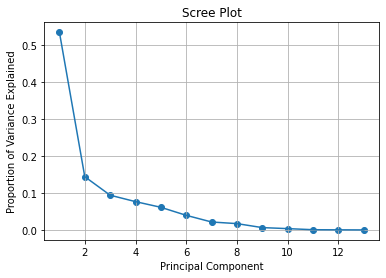

In [10]:
importance = pca.explained_variance_ratio_
plt.scatter(range(1,14),importance)
plt.plot(range(1,14),importance)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

另一種更直覺的圖則是累積解釋比例圖，我們可以看隨著取的主成份越多，累積解釋原本資料的能力的變化情形

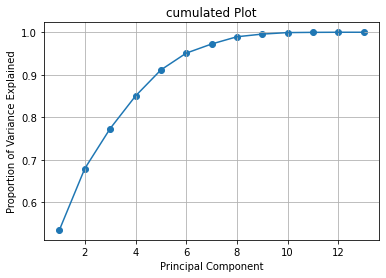

In [11]:
cumulated = []
total = 0
for i in importance:
    total+= i
    cumulated.append(total)

plt.scatter(range(1,14),cumulated)
plt.plot(range(1,14),cumulated)
plt.title('cumulated Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

很直覺的是當我們取了 3 個主成份時，可以解釋原資料中百分之八十左右的變異量

## 5. 線性組合的係數
每一個主成份，都是原特徵值經過線性組合後所產生的值，若原本有 n 個原變數（columns），則可以投影出 n 個主成份。

比如說：

$PC_1 = ∅_{11}X_1+∅_{12}X_2+...+∅_{1n}X_n$<br>
$PC_2 = ∅_{21}X_1+∅_{22}X_2+...+∅_{2n}X_n$<br>
$PC_3 = ∅_{31}X_1+∅_{32}X_2+...+∅_{3n}X_n$<br>
$PC_n = ∅_{n1}X_1+∅_{n2}X_2+...+∅_{nn}X_n$<br>

我們在得到 PCA 之後，為了解釋我們的結果，我們可以試著觀察一下每個主成份的係數組成來說明，其中，觀察原變數在線性組合中的係數(Φ；特徵向量)，可以知道主成份和原變數之間的關係(例如：正影響/負影響；影響程度多大)。

In [12]:
factor_loading = pd.DataFrame(pca.components_.T,index=columns)
factor_loading.columns = ["PC"+str(pc) for pc in list(range(1,14))]
factor_loading

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
R,0.351228,0.027569,0.070960,-0.107178,0.078357,-0.143095,-0.133761,0.121469,-0.548094,-0.139400,0.332736,-0.600417,0.094353
H,0.303660,-0.312693,-0.049345,0.257501,-0.011225,0.100329,0.033132,0.121972,-0.114707,0.725680,0.233598,0.212612,0.272637
2B,0.273259,-0.184970,0.080498,0.063585,0.037302,0.676169,-0.566407,-0.124654,0.168955,-0.186673,0.044003,-0.014751,-0.140759
3B,0.016210,-0.425233,-0.286848,-0.418104,0.568084,-0.141897,0.032995,-0.452481,0.027797,0.072700,0.018670,-0.005123,-0.081278
HR,0.287663,0.267082,0.163383,0.145035,-0.074036,-0.470875,-0.277419,-0.293568,0.218475,0.224877,0.206623,0.060562,-0.510192
RBI,0.354813,0.034868,0.038837,-0.081374,0.075023,-0.117625,-0.100564,0.076789,-0.513683,-0.227956,-0.332143,0.631690,-0.062944
SB,-0.028392,-0.296307,0.682106,-0.285565,0.224883,-0.170665,-0.064472,0.459003,0.258241,0.006688,0.022228,0.052177,-0.008983
CS,-0.152526,-0.353567,0.489239,-0.008129,-0.445168,0.033321,0.156167,-0.554901,-0.279617,-0.004618,-0.042316,-0.024896,0.009798
BB,0.115877,0.512303,0.218244,-0.460712,0.082913,0.318419,0.088294,-0.125046,-0.058056,0.453270,-0.322627,-0.138838,0.017638
SO,-0.085447,0.177990,0.330860,0.586782,0.625978,0.120895,0.224267,-0.177530,-0.115139,-0.068522,-0.015403,-0.026937,0.006700


- 從以上表格我們可以發現在第一主成份中，得分、安打（一二三全壘打）、得分、四壞球都是正相關，可以推論與**成功的打擊**有關
- 第二主成份正相關的有全壘打、四壞球、三振，與**投手對決**有關

## 6. 主成份負荷圖
我們可以藉有繪出主成份負荷圖來觀察每支球隊的特性是什麼：

In [13]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(10,4))
    plt.scatter(xs * scalex,ys * scaley, c = np.arange(30))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

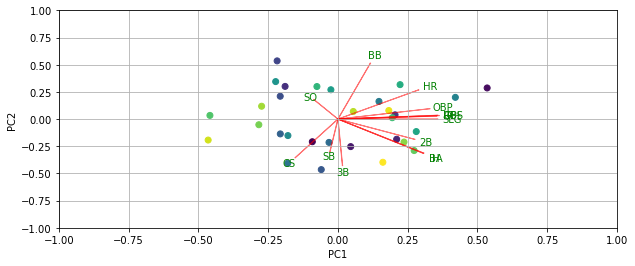

In [14]:
myplot(pca.transform(data_std),np.transpose(pca.components_[0:2, :]), labels=columns)
plt.show()

這張圖可以發現一個有趣的結果，如果有看棒球的球迷會發現一些事
- 靠近右上的球隊，通常都是出現四壞球、全壘打、打點等，這類型的球隊通常在現代棒球會被稱為“飛球革命”後的球隊，又稱 TTO 類型球隊
- 而靠近右下角的球隊的表現比較偏向傳統攻擊型球隊，透過不斷安打來取得分數
- 左下角的球隊就比較有類似小球、戰術風格的球隊，會不斷執行盜壘來作為攻擊手段

## 7. 總結
本篇以 2020 年美國職棒資料進行主成份分析作為示範，練習如何挑選幾個主成份，並且對於背後所代表的意義進行衍伸探討。

主成份分析是一種非監督式學習的方法，在進行的時候要先做正規化避免受到誤差產生影響。此外，因為該方法是對原始的資料進行投影、旋轉等，因此有時候在解釋上會較難以解釋，然而，只要能從主成份中找到有趣的故事，可能就能從中發現一些有價值的策略或者理解。

## 8. 參考資源
- R筆記–(7)主成份分析(2012美國職棒MLB)
https://rpubs.com/skydome20/R-Note7-PCA
- sklearn PCA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Principal component analysis (PCA) and visualization using Python
https://www.reneshbedre.com/blog/principal-component-analysis.html